<a href="https://colab.research.google.com/github/FelipeFerAl/ImageProcessing/blob/main/Talleres/Taller1_PDI_2024_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias y carga de datos

In [153]:
import numpy as np
import zipfile
import os
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.morphology import binary_erosion, binary_dilation, rectangle, square, disk
from skimage.morphology import convex_hull_image, skeletonize, binary_opening, binary_closing

In [3]:
!git clone https://github.com/FelipeFerAl/ImageProcessing.git

path = '/content/ImageProcessing/images.zip'

extract_path = os.path.dirname('/content/images')

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

clear_output(False)

#EJERCICIO #1
Tomamos la imagen y la convertimos a formato HSV para facilitar el proceso de separación de colores en base al matiz, la saturación y el valor del color. Inicialmente se utilizó una página externa para detectar algunos valores de los colores, otros fueron ensayo y error

In [4]:
# Carga de la imagen
im=mpimg.imread('/content/images/llaves.jpg')

# Conversión a HSV
hsv_image = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

In [5]:
# Rangos de color en HSV
color_ranges = {
    'black': ((0, 0, 0), (50, 50, 50)),
    'red': ((0, 200, 100), (10, 255, 255)),
    'green': ((40, 50, 50), (80, 255, 255)),
    'blue': ((90, 200, 150), (100, 255, 255)),
}

# Máscaras
masks = {color: cv2.inRange(hsv_image, np.array(lower), np.array(upper))
        for color, (lower, upper) in color_ranges.items()}

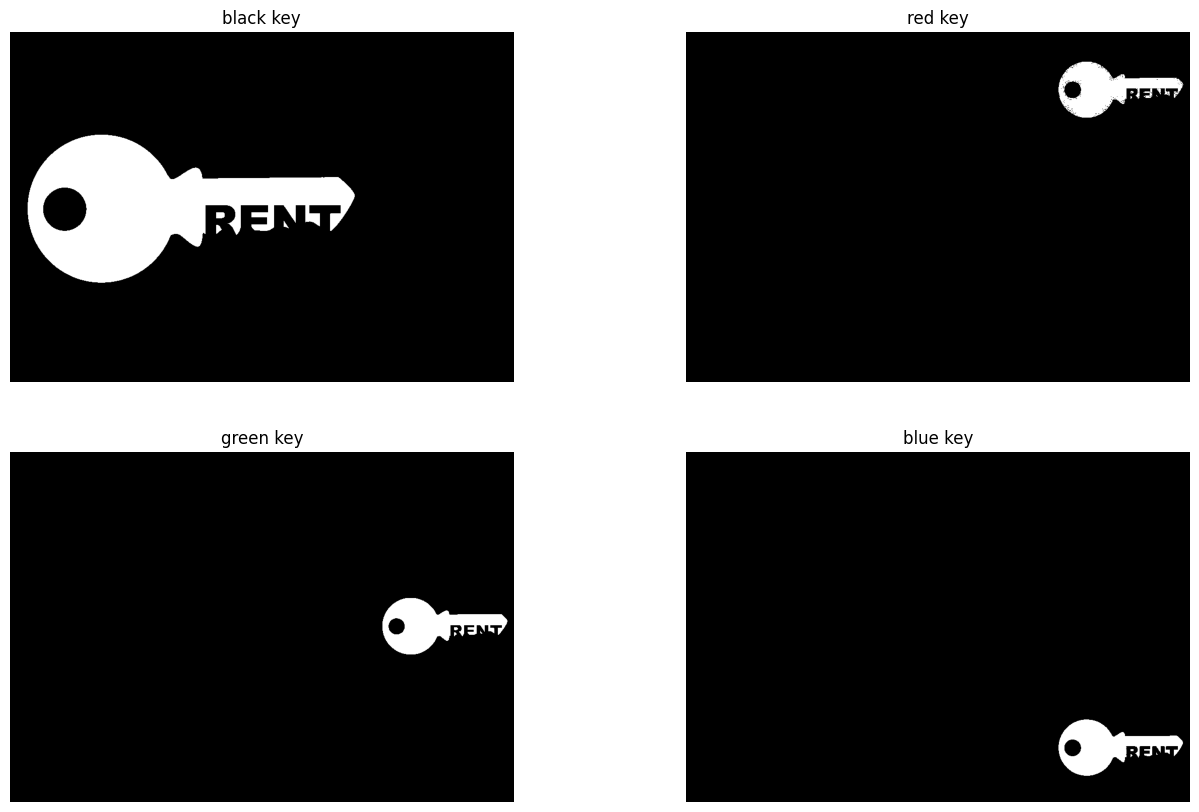

In [6]:
# Figuras
plt.figure(figsize=(16, 10))
for row in range(2):
  for col in range(2):
    idx = row * 2 + col + 1
    plt.subplot(2, 2, idx)
    plt.imshow(masks[list(masks.keys())[idx - 1]], cmap='gray')
    plt.title(list(masks.keys())[idx - 1]+' key')
    plt.axis('off')

#Ejercicio #2
Ambos formatos se convierten en base a fórmulas de normalización y para hallar cada componente necesario en cada pixel. Para el caso de la conversión CMYK se imprime cada una de las capas ya que visualizar los 4 componentes juntos es más complejo

In [7]:
class image_conv:
  def __init__(self, image):
    self.image = image

  def RGB2HSV(self):
    # Separo los componentes de RGB y los normalizo
    r = self.image[:, :, 0]/255
    g = self.image[:, :, 1]/255
    b = self.image[:, :, 2]/255

    # Máximo y mínimo de cada componente para
    # hallar el delta para calcular el matiz
    c_max = np.maximum.reduce([r, g, b])
    c_min = np.minimum.reduce([r, g, b])
    delta = c_max - c_min

    # Inicializamos vectores para la matiz y la saturación, el valor
    # es definido por el máximo de cada componente
    h = np.zeros_like(c_max)
    s = np.zeros_like(c_max)
    v = c_max

    # Calculamos el matiz
    mask = delta != 0
    r_eq = (c_max == r) & mask
    g_eq = (c_max == g) & mask
    b_eq = (c_max == b) & mask

    # Conversiones de las ecuaciones de transformación
    h[r_eq] = (60 * ((g[r_eq] - b[r_eq]) / delta[r_eq]) % 360)
    h[g_eq] = (60 * ((b[g_eq] - r[g_eq]) / delta[g_eq]) + 120)
    h[b_eq] = (60 * ((r[b_eq] - g[b_eq]) / delta[b_eq]) + 240)

    # Normalizar H en el campo de 360º del cono de HSV
    h = np.where(h < 0, h + 360, h)

    # Cálculo de la saturación
    s[c_max != 0] = delta[c_max != 0] / c_max[c_max != 0]

    # Conversión a rangos CV2 para impresión
    h_opencv = (h / 2).astype(np.uint8)
    s_opencv = (s * 255).astype(np.uint8)
    v_opencv = (v * 255).astype(np.uint8)

    # Combinamos las 3 capas para formar una sola imágen transformada
    hsv_image = np.stack([h_opencv, s_opencv, v_opencv], axis=-1)
    plt.imshow(hsv_image)
    plt.title('HSV image')
    plt.axis('off')

  def RGB2CMYK(self):
    # Normalizar vectores de color entre 0 y 1
    r = self.image[:, :, 0] / 255.0
    g = self.image[:, :, 1] / 255.0
    b = self.image[:, :, 2] / 255.0

    # Calcular K, componente en negro, es la resta del resto de componentes:
    # Celeste, Magenta y Amarillo
    k = 1 - np.maximum.reduce([r, g, b])

    # Evitamos la división entre 0
    c = np.zeros_like(k)
    m = np.zeros_like(k)
    y = np.zeros_like(k)

    mask = k < 1  #Si el pixel no es negro, debe aplicar a alguna máscara
    c[mask] = (1 - r[mask] - k[mask]) / (1 - k[mask])
    m[mask] = (1 - g[mask] - k[mask]) / (1 - k[mask])
    y[mask] = (1 - b[mask] - k[mask]) / (1 - k[mask])

    # Escalamos para volver a CV2 para impresión
    c_scaled = (c * 255).astype(np.uint8)
    m_scaled = (m * 255).astype(np.uint8)
    y_scaled = (y * 255).astype(np.uint8)
    k_scaled = (k * 255).astype(np.uint8)

    colors = {
        'cyan': c_scaled,
        'magenta': m_scaled,
        'yellow': y_scaled,
        'black': k_scaled
    }
    for row in range(2):
      for col in range(2):
        idx = row * 2 + col + 1
        plt.subplot(2, 2, idx)
        plt.imshow(colors[list(colors.keys())[idx - 1]])
        plt.title(list(colors.keys())[idx - 1]+' intensity')
        plt.axis('off')

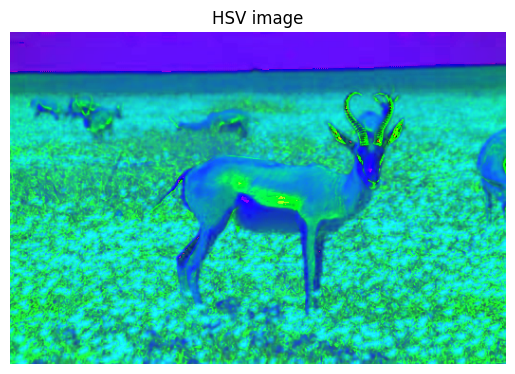

In [8]:
Conversion1 = image_conv(mpimg.imread('/content/images/antelops.jpeg'))
Conversion1.RGB2HSV()

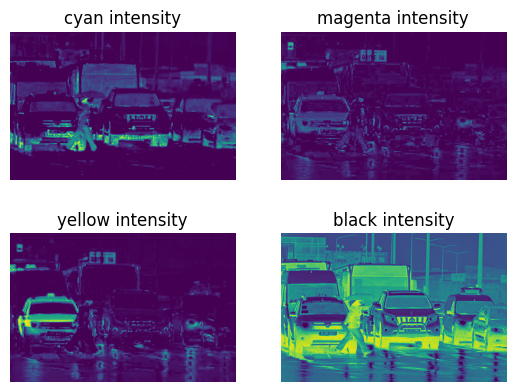

In [9]:
Conversion2 = image_conv(mpimg.imread('/content/images/cars.jpg'))
Conversion2.RGB2CMYK()

# Ejercicio #3

In [10]:
class image_size:
  def __init__(self, image):
    self.image = image

  def scaling(self, scale):
    y_original, x_original, channels = self.image.shape
    scaled_x = int(scale * x_original)
    scaled_y = int(scale * y_original)

    scaled_image = np.zeros((scaled_y, scaled_x, channels), dtype=self.image.dtype)  #Canvas
    for y_new in range(scaled_y):
      for x_new in range(scaled_x):
        # Mapeo de los pixeles con la imagen original
        x_orig = int(x_new / scale)
        y_orig = int(y_new / scale)

        # Los valores de pixeles se asignan por vecino más cercano
        scaled_image[y_new, x_new] = self.image[y_orig, x_orig]
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(self.image)
    plt.title(f'Original image, {x_original}x{y_original}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(scaled_image)
    plt.title(f'Scaled image, {scaled_x}x{scaled_y}')
    plt.axis('off')

  def shaping(self, x_desired, y_desired):
    y_original, x_original = self.image.shape[:2]
    scale_x = x_desired / x_original
    scale_y = y_desired / y_original

    scaled_image = np.zeros((y_desired, x_desired, self.image.shape[2]), dtype=self.image.dtype)  #Canvas
    for i in range(y_desired):
      for j in range(x_desired):
        # Escalado de pixeles entre la original y la escalada
        original_x = int(j / scale_x)
        original_y = int(i / scale_y)

        # Los índices i,j deben mantenerse dentro de los límites
        original_x = min(original_x, x_original - 1)
        original_y = min(original_y, y_original - 1)

        # Los valores de pixeles se asignan por vecino más cercano
        scaled_image[i, j] = self.image[original_y, original_x]
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(self.image)
    plt.title(f'Original image, {x_original}x{y_original}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(scaled_image)
    plt.title(f'Reshaped image, {x_desired}x{y_desired}')
    plt.axis('off')

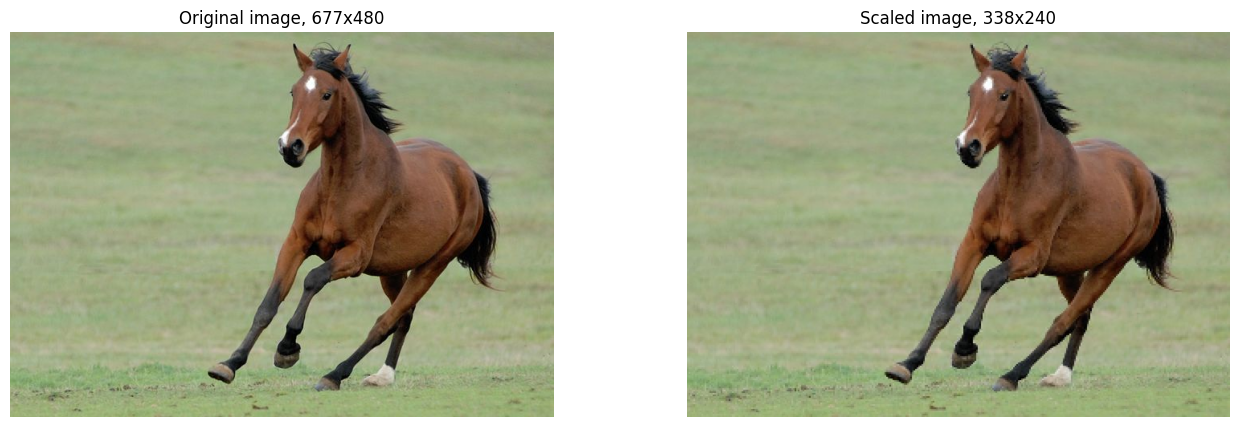

In [11]:
forma1 = image_size(mpimg.imread('/content/images/horse.jpg'))
forma1.scaling(0.5)

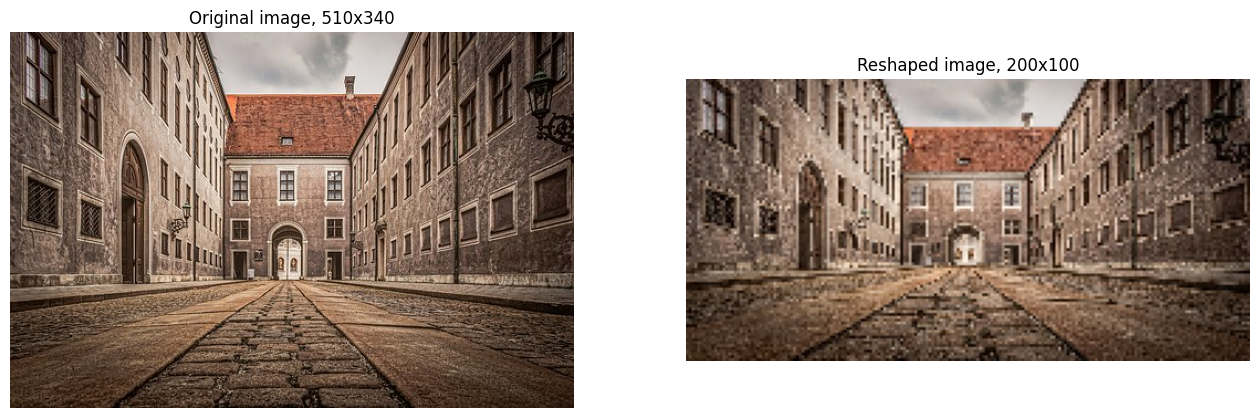

In [12]:
forma2 = image_size(mpimg.imread('/content/images/house.png'))
forma2.shaping(200, 100)

#Ejercicio #4

(-0.5, 508.5, 340.5, -0.5)

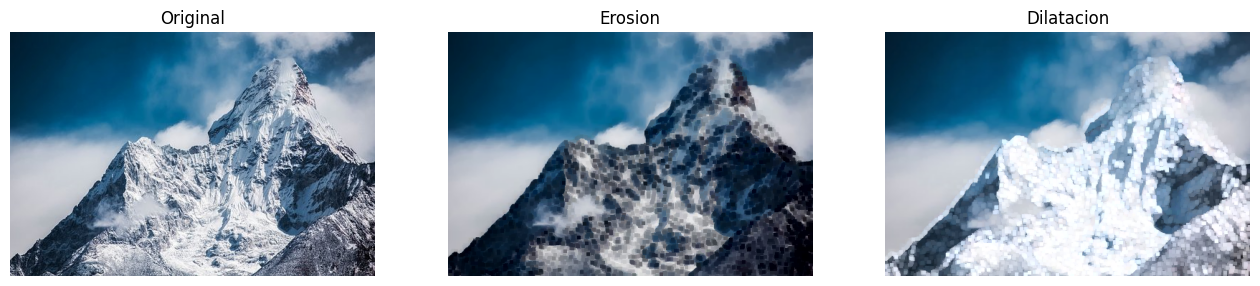

In [37]:
#@title Erosion y Dilatación
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(mpimg.imread('/content/images/mountain.png'))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.erode(mpimg.imread('/content/images/mountain.png'),kernel,iterations = 1))
plt.title('Erosion')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.dilate(mpimg.imread('/content/images/mountain.png'),kernel,iterations = 1))
plt.title('Dilatacion')
plt.axis('off')

(-0.5, 524.5, 349.5, -0.5)

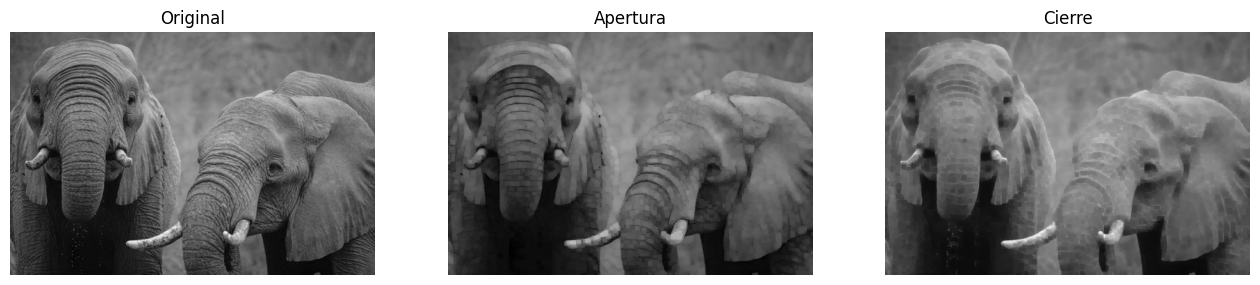

In [38]:
#@title Apertura y Cierre
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(mpimg.imread('/content/images/elephant_g.jpg'))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.morphologyEx(mpimg.imread('/content/images/elephant_g.jpg'), cv2.MORPH_OPEN, kernel))
plt.title('Apertura')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.morphologyEx(mpimg.imread('/content/images/elephant_g.jpg'), cv2.MORPH_CLOSE, kernel))
plt.title('Cierre')
plt.axis('off')

(-0.5, 676.5, 479.5, -0.5)

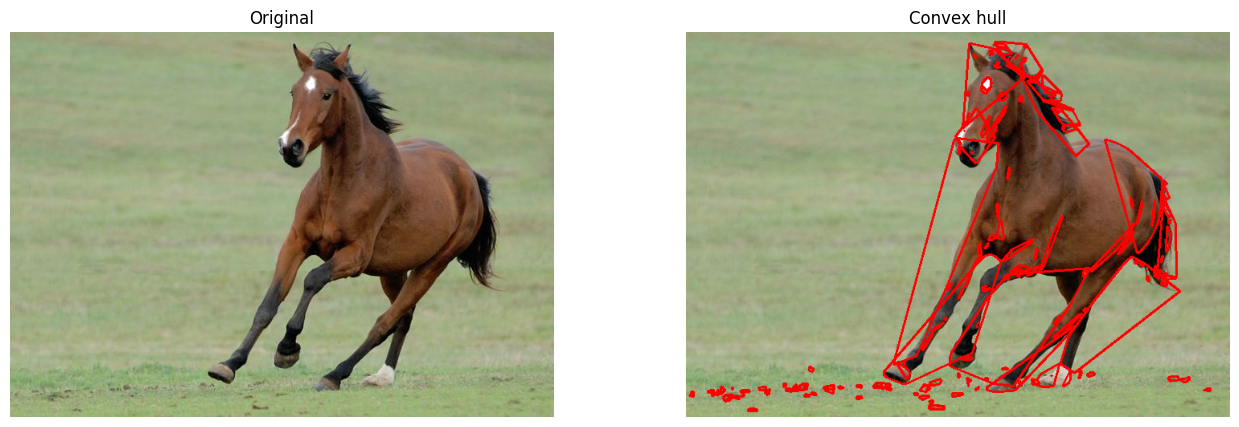

In [45]:
#@title Convex Hull
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread('/content/images/horse.jpg'))
plt.title('Original')
plt.axis('off')

original_image = mpimg.imread('/content/images/horse.jpg')
binary_image = cv2.Canny(original_image, 100, 200)  # Se pasa a binario
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)  # Se hallan los puntos necesarios para contener la imagen
processed_image = original_image.copy()
for contour in contours:
    convex_hull = cv2.convexHull(contour)  # Se hallan los contornos convexos
    cv2.drawContours(processed_image, [convex_hull], -1, (255, 0, 0), 2)  # Se dibujan los contornos en base a los puntos

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title('Convex hull')
plt.axis('off')

(-0.5, 302.5, 339.5, -0.5)

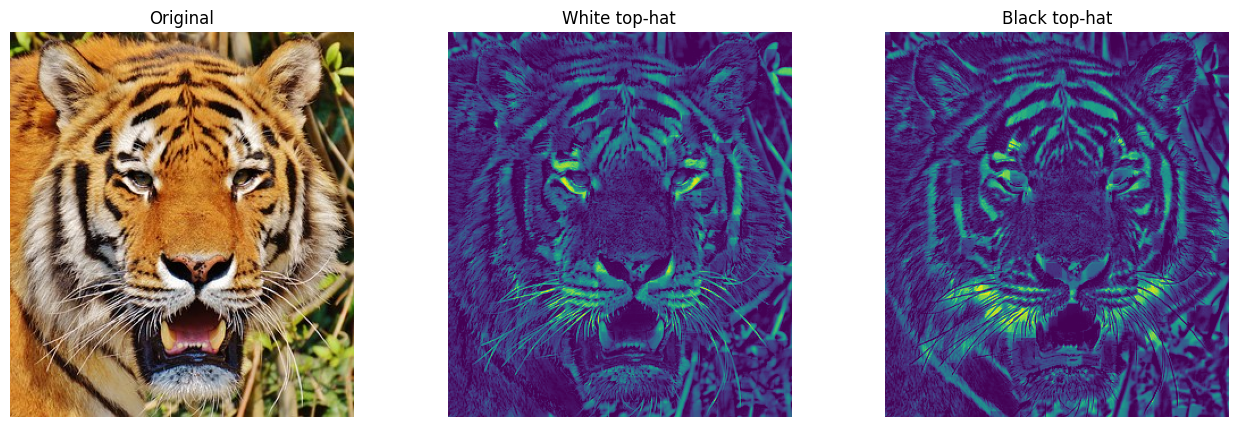

In [44]:
#@title White top-hat y Black top-hat
image = cv2.cvtColor(mpimg.imread('/content/images/tiger3.jpg'), cv2.COLOR_RGB2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
white_tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
black_tophat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(mpimg.imread('/content/images/tiger3.jpg'))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(white_tophat)
plt.title('White top-hat')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(black_tophat)
plt.title('Black top-hat')
plt.axis('off')

(-0.5, 339.5, 339.5, -0.5)

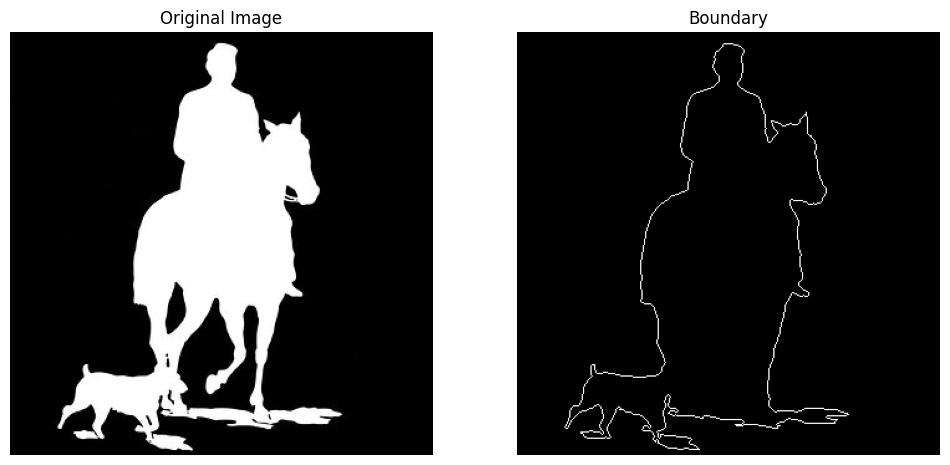

In [49]:
#@title Boundary o contorno
image = cv2.imread('/content/images/horse-dog.jpg', cv2.IMREAD_GRAYSCALE) # Carga imagen en gris
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) # La pasamos a imagen binaria
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Se hallan los puntos
boundary_image = np.zeros_like(image)
cv2.drawContours(boundary_image, contours, -1, (255), 1)  # Se realiza el dibujo del contorno

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(boundary_image, cmap='gray')
plt.title('Boundary')
plt.axis('off')

# Ejercicio #5

In [124]:
def binary_image(image):
  """
  Función para crear la imagen binaria de cualquier archivo
  """
  im = rgb2gray(image)
  im[im <= 0.5] = 0
  im[im > 0.5] = 1
  return im

In [170]:
class binary_image_operations:
  def __init__(self, image):
    self.image = image

  def erosion(self, structure):
    eroded_image = binary_erosion(self.image, structure)
    plt.imshow(eroded_image, cmap='gray')
    plt.title('Erosion')
    plt.axis('off')

  def dilatacion(self, structure):
    dilated_image = binary_dilation(self.image, structure)
    plt.imshow(dilated_image, cmap='gray')
    plt.title('Dilatacion')
    plt.axis('off')

  def opening(self, structure):
    opened_image = binary_opening(self.image, structure)
    plt.imshow(opened_image, cmap='gray')
    plt.title('Opening')
    plt.axis('off')

  def closing(self, structure):
    closed_image = binary_closing(self.image, structure)
    plt.imshow(closed_image, cmap='gray')
    plt.title('Closing')
    plt.axis('off')

  def skeletonize(self):
    skeleton = skeletonize(self.image)
    plt.imshow(skeleton, cmap='gray')
    plt.title('Skeletonize')
    plt.axis('off')

  def convex_hull(self):
    chimage = convex_hull_image(self.image)
    plt.imshow(chimage, cmap='gray')
    plt.title('Convex hull')
    plt.axis('off')

In [171]:
imagen1 = binary_image_operations(binary_image(mpimg.imread('/content/images/squirrel.jpg')))
imagen2 = binary_image_operations(binary_image(mpimg.imread('/content/images/parrot.jpg')))
imagen3 = binary_image_operations(binary_image(mpimg.imread('/content/images/zebras.jpg')))
imagen4 = binary_image_operations(binary_image(mpimg.imread('/content/images/horse-dog.jpg')))

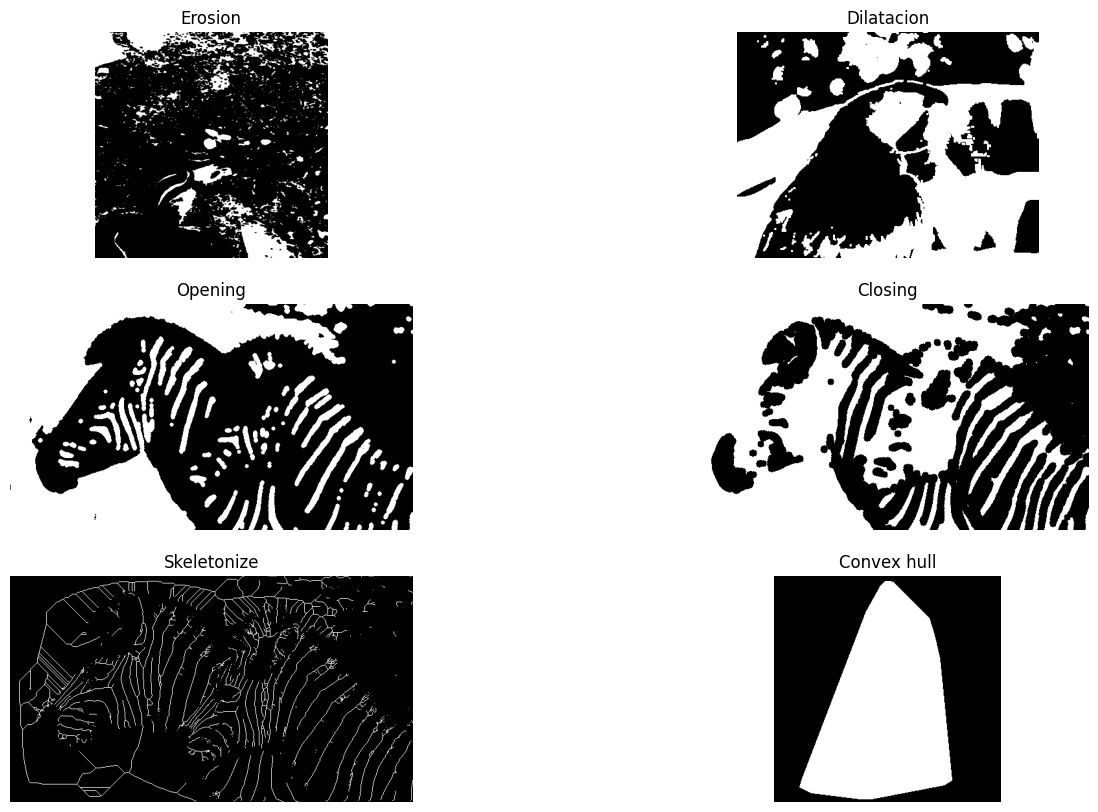

In [173]:
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1)
imagen1.erosion(rectangle(3,5))
plt.subplot(3, 2, 2)
imagen2.dilatacion(square(3))
plt.subplot(3, 2, 3)
imagen3.opening(disk(3))
plt.subplot(3, 2, 4)
imagen3.closing(disk(5))
plt.subplot(3, 2, 5)
imagen3.skeletonize()
plt.subplot(3, 2, 6)
imagen4.convex_hull()